In [30]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import vmap, jit
from jax.experimental import loops
from jax.ops import index_update, index_add
import matplotlib.pyplot as plt
from functools import partial

In [55]:
def simultaneous_isotonic_regression(X, Ys, y_min=0, y_max=1):
    """
    Run PAVA simultaneously on many problem instances. 
    Each problem must have the same independent variables, but we parallelize
    over different observations.
    
    Args
        X: (num_measurements)
        Ys: (num_problems x num_measurements)
        
    Returns
    
        Y_hats: (num_problems x num_measurements) where each row is the result of running an isotonic
                 regression.
    
    """
    
    
    idx = jnp.argsort(X)
    X_s = X[idx]
    Y_s = Ys[:,idx]
    
    
    
    X_unique = jnp.unique(X_s)
    num_unique = len(X_unique)
    
    assert num_unique == X.shape[0], "Repeated values in X not yet supported"
    
    X_unique, Ys_unique = vmap(make_unique_fixed,
        in_axes=(None, 0, None, None))(X_s, Y_s, X_unique, num_unique)
    Y_preds = vmap(_pava, in_axes=(None, 0))(X_unique, Ys_unique)
    return jnp.clip(Y_preds, a_min=y_min, a_max=y_max)
    
@jit
def _pava(X_unique, Y_unique):

    with loops.Scope() as s:
        
        s.lhs = 0
        s.rhs = 0
        s.block_assignments = jnp.zeros_like(Y_unique, dtype=int)
        s.block_vals = jnp.zeros_like(Y_unique, dtype=float)
        s.curr_block_size = 0
        s.curr_block_sum = 0.0
        s.block_idx = 0
        n = len(Y_unique)

        # equivalent:
        # while rhs < n:
        for _ in s.while_range(lambda: s.rhs < n):
            s.curr_block_size = 0
            s.curr_block_sum = 0.0
            
            # equivalent:
            # while rhs < n and y[rhs] <= y[lhs]
            for _ in s.while_range(lambda: 
                    jnp.logical_and(s.rhs < n, Y_unique[s.rhs] <= Y_unique[s.lhs])):
                #block_assignments[rhs] = block_idx
                s.block_assignments = index_update(s.block_assignments, s.rhs, s.block_idx)
                
                s.curr_block_size += 1
                s.curr_block_sum += Y_unique[s.rhs]
                s.rhs += 1


            # done with decreasing subsequence
            # equivalent: block_vals[block_idx] = curr_block_sum / curr_block_size
            s.block_vals = index_update(s.block_vals, s.block_idx,
                s.curr_block_sum.astype(float) / s.curr_block_size.astype(float))
            s.lhs = s.rhs
            s.block_idx += 1

        # pass through the data to create the prediction \hat y
        s.Y_out = jnp.zeros_like(Y_unique)
        s.idx = 0
        for i in s.range(n):
            s.idx = s.block_assignments[i]
            s.Y_out = index_update(s.Y_out, i, s.block_vals[s.idx])
    
        return s.Y_out
    
@partial(jit, static_argnums=(3,))
def make_unique_fixed(X, Y, X_unique, num_unique):
    # vmap-friendly version of make_unique_flexible.
    # Gets rid of duplicate independent variables in X,
    # and averages the corresponding obervations in Y.
    # NOTE: Assumes X and Y are sorted.
    
    with loops.Scope() as s:
        s.Y_out = jnp.empty(num_unique)
        
        for i in s.range(num_unique):
            curr_val = X_unique[i]
            avg_y = jnp.nanmean(jnp.where(X == curr_val, Y, jnp.nan))
            s.Y_out = index_update(s.Y_out, i, avg_y)
            
        return X_unique, s.Y_out
    
def make_unique_flexible(X, Y, eps=1e-8):
    # Get rid of duplicate independent variables and associated observations
    # by averaging. In this case, we consider independent vars. X within some
    # tolerance to be the same.
    # 
    # This is a direct copy of the implementation from sklearn here:
    # https://github.com/scikit-learn/scikit-learn/blob/7e1e6d09bcc2eaeba98f7e737aac2ac782f0e5f1/sklearn/_isotonic.pyx#L66
    # but modified to assume that all weights are equal 1
    n_unique = len(jnp.unique(X))
    n_samples = X.shape[0]
    
    
    with loops.Scope() as s:
        
        s.X_out = jnp.empty(n_unique)
        s.Y_out = jnp.empty_like(s.X_out)

        s.w_cur = 0
        s.x_cur = X[0]
        s.y_cur = 0
        s.i = 0
        s.x = 0
        
        def true_fun(args):
            i, w_cur, j, X_out, Y_out, x, x_cur, y_cur = args
            X_out = index_update(X_out, i, x_cur)
            Y_out = index_update(Y_out, i, y_cur / w_cur)
            x_cur = x
            y_cur = Y[j]
            i += 1
            w_cur = 1
            return i, w_cur, X_out, Y_out, x_cur, y_cur
            
        def false_fun(args):
            i, w_cur, j, X_out, Y_out, x, x_cur, y_cur = args
            y_cur += Y[j]
            w_cur += 1
            return i, w_cur, X_out, Y_out, x_cur, y_cur
    
        for j in s.range(n_samples):
            s.x = X[j]
            
            s.i, s.w_cur, s.X_out, s.Y_out, s.x_cur, s.y_cur = jax.lax.cond(
                s.x - s.x_cur >= eps,
                true_fun,
                false_fun,
                (s.i, s.w_cur, j, s.X_out, s.Y_out, s.x, s.x_cur, s.y_cur),
            )
        
        s.X_out = index_update(s.X_out, s.i, s.x_cur)
        s.Y_out = index_update(s.Y_out, s.i, s.y_cur / s.w_cur)
        
        return s.X_out[:s.i+1], s.Y_out[:s.i+1]
    

    

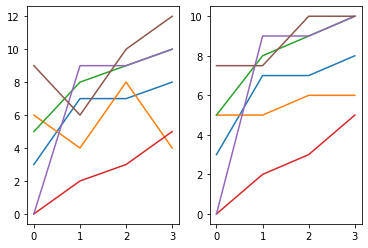

In [56]:
num_problems = 6
X = jnp.array([0,25,30,35]) # 3 unique powers
num_powers = X.shape[0]
Ys = jnp.array(np.random.randint(0,high=10, size=(num_problems,num_powers)) + np.arange(num_powers))

Y_preds = simultaneous_isotonic_regression(X, Ys, y_min=0, y_max=10)

fig, axs = plt.subplots(1,2,)
axs[0].plot(Ys.T)
axs[1].plot(Y_preds.T)

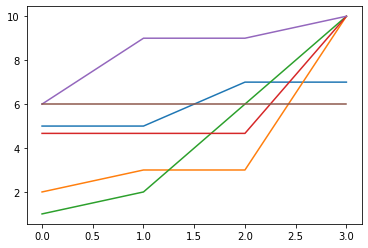

In [57]:
# Compare results to sklearn.isotonic
from sklearn.isotonic import IsotonicRegression
isotonic_regressor = IsotonicRegression(y_min=0, y_max=10, increasing=True)

Y_preds_sklearn = np.stack([isotonic_regressor.fit_transform(X,y)for y in Ys], axis=0)
plt.plot(Y_pred_sklearn.T)

In [58]:
np.allclose(Y_preds, Y_preds_sklearn)

True